In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from tinydb import TinyDB

import candas as can
from candas.test import QuantStudio
import pathlib as pl


code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["lines.linewidth"] = 2

In [3]:
width = 3.45
height = 2.75 + 0.2
figsize = (width, height)
spotsize = 4**2
ticklabelsize = 5
labelsize = 6
titlesize = 8
linewidth = 1

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.3
mar_r = 0.3
mar_t = 0.22
mar_b = 0.275 + 0.2
ax_space = 0.075


def format_sns_axes(fig, axs, axes_dict, xticks, xlim, ylim=None, width=width, height=height, mar_b=mar_b, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, ax_space=ax_space, hline=True):
    fig.set_size_inches((width, height))

    ylim = ylim or [-1.1, 1.1]

    plt.setp(
        axs,
        ylim=ylim,
        yticks=[-1, -0.5, 0, 0.5, 1],
        xticks=xticks,
        xlim=xlim,
        title="",
    )
    for i, ax in enumerate(axs.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        # if i > 0:
        #     ax.yaxis.set_tick_params(length=0)
        if hline:
            ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

    for (row, col), ax in axes_dict.items():
        ax.set_title("")

        if col == 8.0:
            ax2 = ax.twinx()
            ax2.set_yticks([])
            ax2.set_ylabel(
                f"{row:.1f}", va="bottom", fontsize=labelsize, rotation=270, labelpad=1
            )
            if row == 5.0:
                ax2.set_ylabel(
                    f"log$_{1}$$_{0}$ Copies Competitor 2\n{row:.1f}",
                    va="bottom",
                    fontsize=labelsize,
                    rotation=270,
                    labelpad=1,
                )

        if row == 8.0:
            ax.set_title(f"{col:.1f}", fontsize=labelsize, pad=2)
            if col == 5.0:
                ax.set_title(
                    f"log$_{1}$$_{0}$ Copies Competitor 1\n{col:.1f}",
                    fontsize=labelsize,
                    pad=2,
                )

        if ax != axs[-1, 0]:
            ax.set_xlabel("")
            ax.set_ylabel("")

    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width, bbox.height

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        wspace=ax_space / ax_width,
        hspace=ax_space / ax_height,
    )

In [4]:
cmax = 50

db_file = data_pth / "JG071B Reaction Specifications.json"
rxn_db = TinyDB(db_file)
JG071B_rxns = pd.DataFrame(
    [rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()]
)


file = data_pth / "JG071B Tripartite sweep GBP6.xlsx"
JG071B = (
    QuantStudio(file, "JG071B")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .drop(lambda df: df["Well"].isin([54, 281]))
    .normalize_reactions(cmax=cmax, method="max")
    .invert_fluorophore("HEX")
)

JG071B.reactions.data = JG071B.reactions.data.merge(JG071B_rxns)
for oligo in ["S036.5", "S057.3.2", "S057.4.2"]:
    JG071B.reactions.data[f"log_{oligo}"] = np.log10(
        JG071B.reactions.data[oligo]
    )

JG071B.extract_endpoints(cmax=cmax, name="FAM-HEX", method="diff")
endpoints_B = JG071B.endpoints
endpoints_B = endpoints_B[endpoints_B.Reporter == "FAM"]

In [5]:
db_file = data_pth / "JG071A Reaction Specifications.json"
rxn_db = TinyDB(db_file)
JG071A_rxns = pd.DataFrame(
    [rxn["oligos"] | {"Sample": rxn["name"]} for rxn in rxn_db.all()]
)

cmax = 50

file = data_pth / "JG071A ARG1 Tripartite.xlsx"
JG071A = (
    QuantStudio(file, "JG071A")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .drop(lambda df: df["Well"].isin([281]))
    .normalize_reactions(cmax=cmax, method="max")
    .invert_fluorophore("HEX")
)

JG071A.reactions.data = JG071A.reactions.data.merge(JG071A_rxns)
for oligo in ["S036.0", "S057.0.1", "S057.1.2"]:
    JG071A.reactions.data[f"log_{oligo}"] = np.log10(
        JG071A.reactions.data[oligo]
    )

JG071A.extract_endpoints(cmax=cmax, name="FAM-HEX", method="diff")
endpoints_A = JG071A.endpoints
endpoints_A = endpoints_A[endpoints_A.Reporter == "FAM"]

In [6]:
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets.pkl")
ps = pd.read_pickle(data_pth / "ADVI_ParameterSets_220528.pkl")
ps = ps[ps.Metric == 'mean']

In [7]:
def get_lg10_Q_fun(data):
    K = data.groupby("lg10_Copies")["K"].mean()
    F0_lg = data.groupby("lg10_Copies")["F0_lg"].mean()
    lg_Q = (
        (F0_lg - np.log10(K) - (7 + 5 - np.log10(6.022e23)))
        .rename("mean")
        .reset_index()
    )
    lg_Q_fun = np.poly1d(np.polyfit(lg_Q.lg10_Copies, lg_Q["mean"], 1))
    return lg_Q_fun

import jax.numpy as jnp

In [8]:
target = np.array([[-1, +1, 0, 0]])
competitor = np.array([[0, -1, +1, 0], [0, 0, -1, +1]])

positive_labels = np.array([[0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0]])

rxn_t = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF1", "REF2"],
    label_names=["H", "F"],
)

rxn_t.n_cycles = 49
rxn_t.compile()


def sym_tripartite(
    ref1_rate,
    ref1_lgQ,
    ref2_rate,
    ref2_lgQ,
    wt_rate=0.9,
    wt_pts = None,
    wt_start=1,
    wt_end=8,
    n_points=100,
    ref1_drift=0,
    ref2_drift=0,
    wt_drift=0,
    wt_lgQ_fun=None,
):

    rxn_t.oligo("WT").rate = wt_rate
    rxn_t.oligo("REF1").rate = ref1_rate
    rxn_t.oligo("REF2").rate = ref2_rate

    rxn_t.oligo("WT").drift = wt_drift
    rxn_t.oligo("REF1").drift = ref1_drift
    rxn_t.oligo("REF2").drift = ref2_drift

    rxn_t.oligo("REF1").copies = 10**ref1_lgQ
    rxn_t.oligo("REF2").copies = 10**ref2_lgQ
    if wt_pts is not None:
        wt_lgQ = wt_pts
    else:
        wt_lgQ = np.linspace(wt_start, wt_end, n_points)
        
    if wt_lgQ_fun is not None:
        arrays = [wt_lgQ_fun(wt_lgQ)]
    else:
        arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_t.sweep_setup = arrays, grids, pts, rxn_t.INT_idxs
    sol = rxn_t.solution_sweep()
    return wt_lgQ, sol

# Hypothetical ideal system: inequal rates

Saving fig_S9A__stretchy_tetra in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


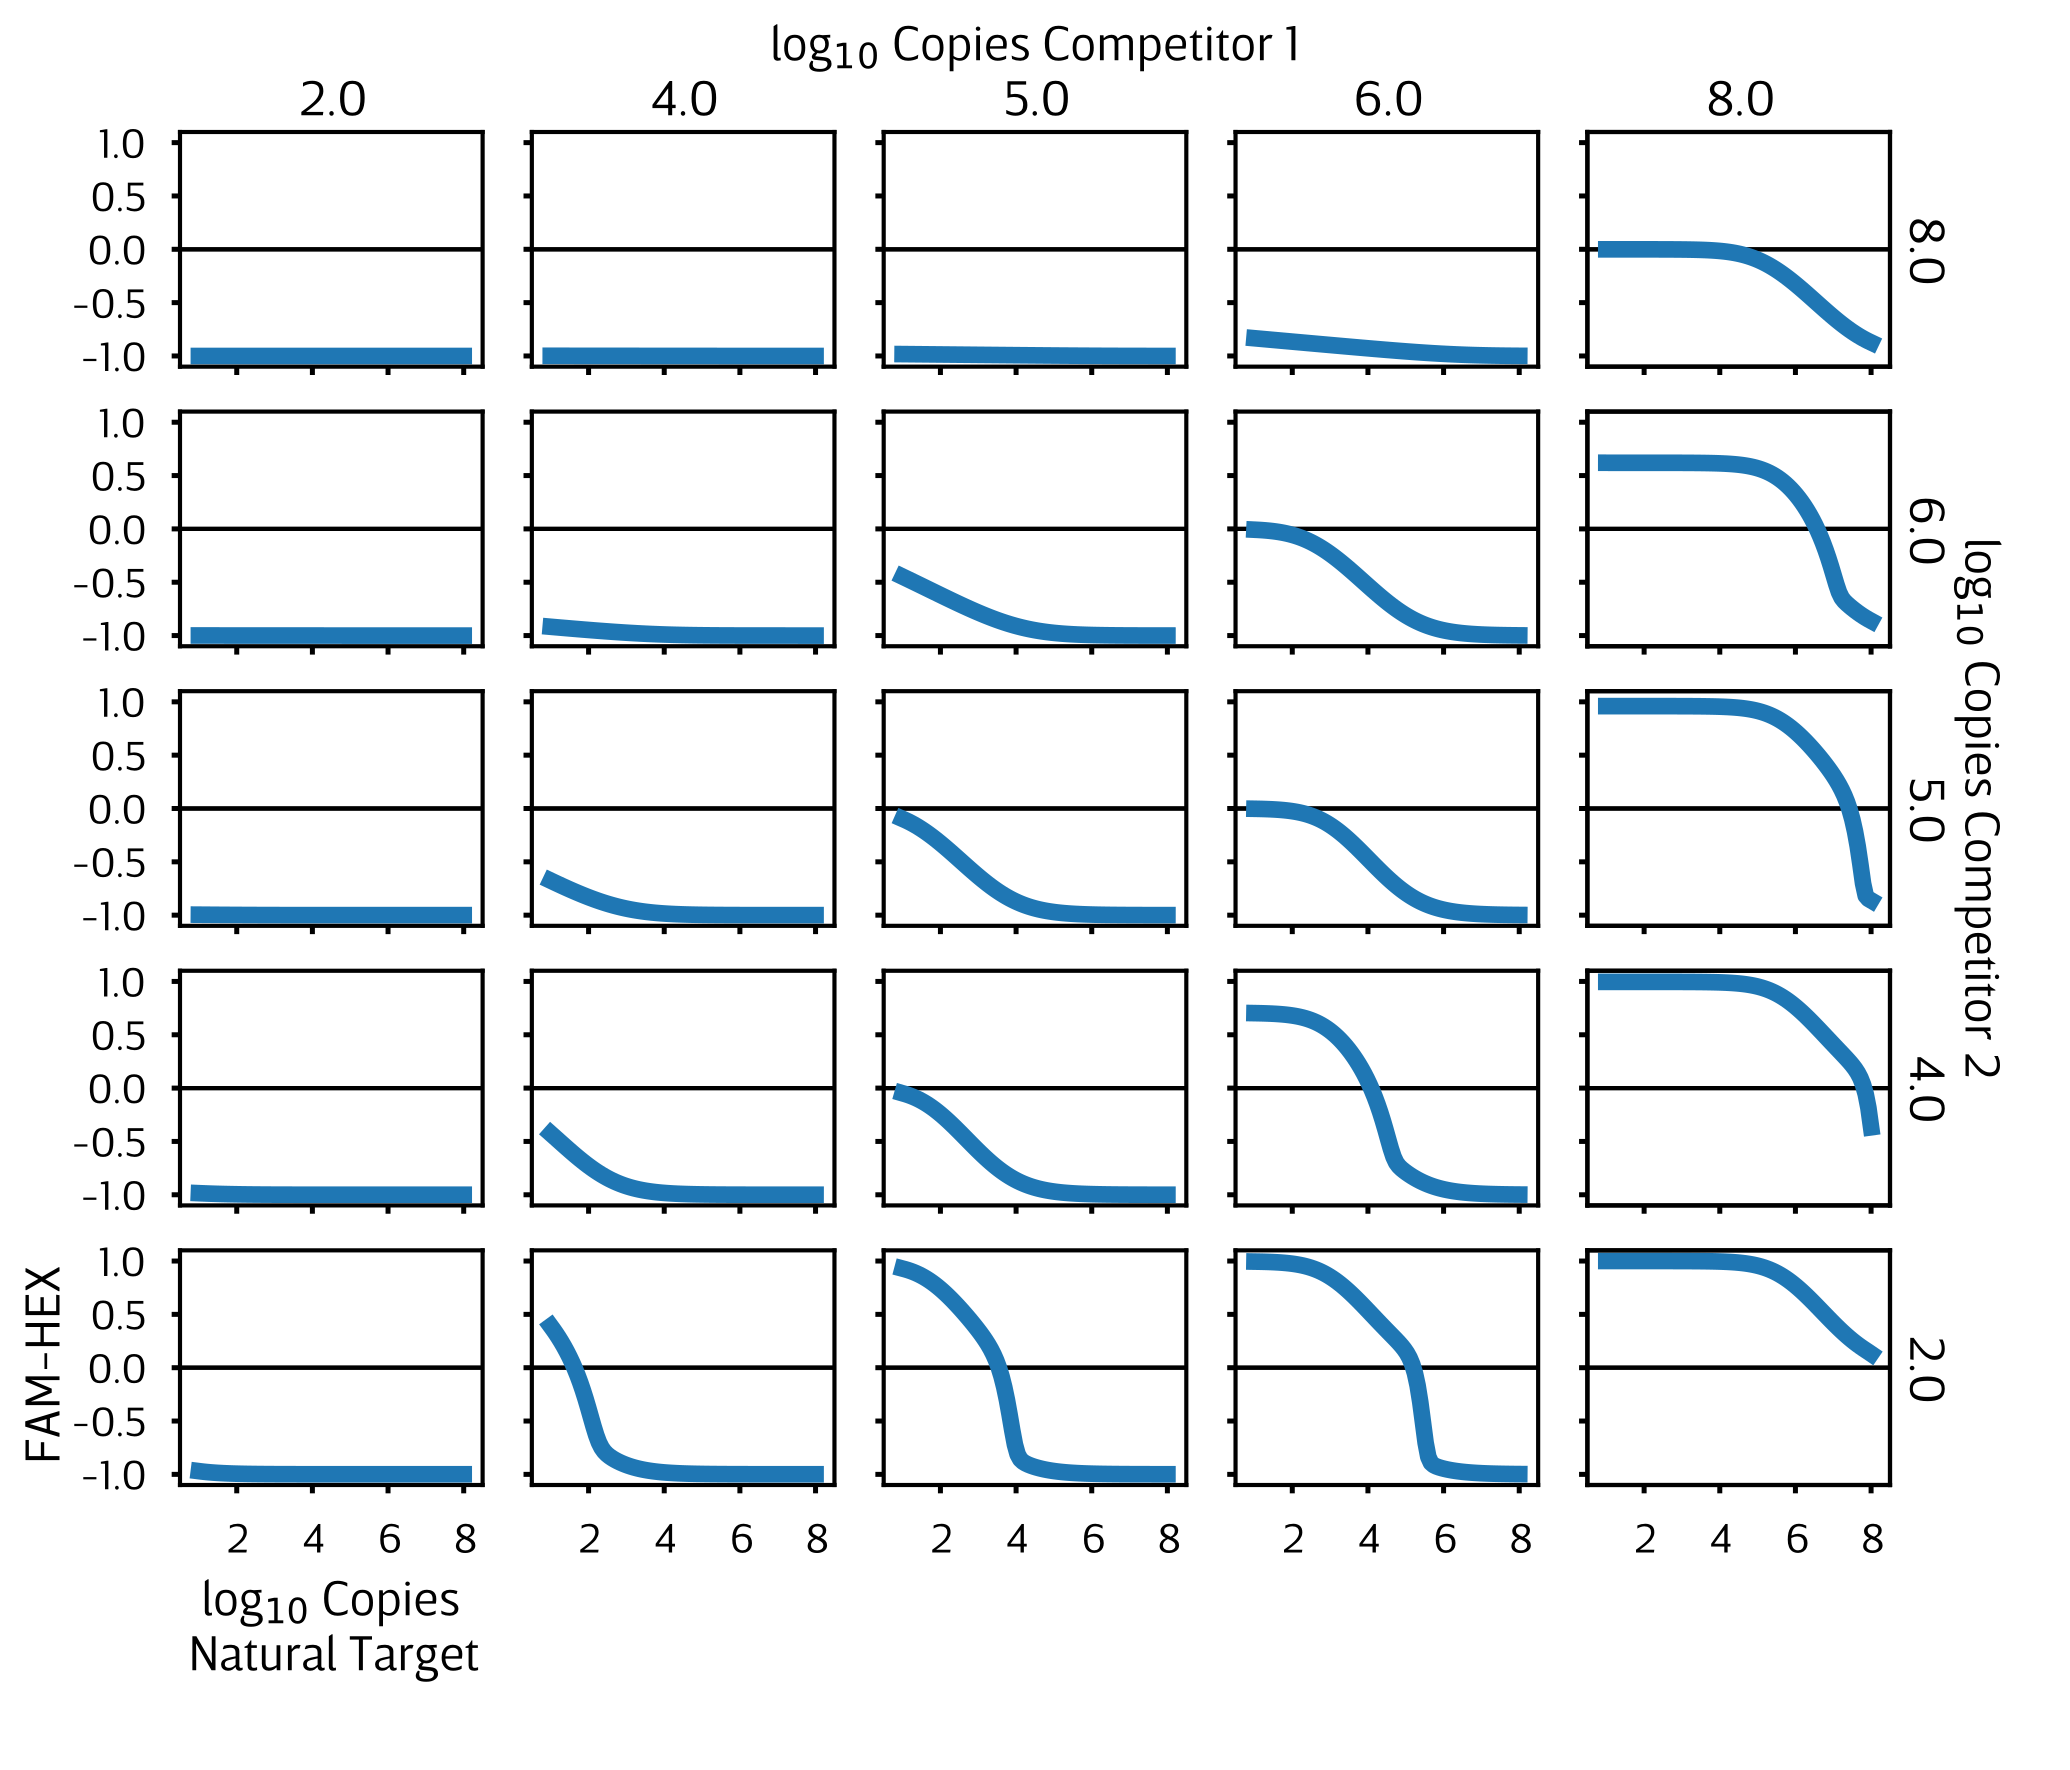

In [9]:
# Hypothetical ideal system

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    wt_lgQ, sol = sym_tripartite(
        ref1_rate=0.6,
        ref1_lgQ=ref1_lgQ,
        ref2_rate=0.6,
        ref2_lgQ=ref2_lgQ,
        wt_rate=0.8,
        wt_lgQ_fun=None,
    )
    ax.plot(wt_lgQ, sol)

    ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(
    r"log$_{10}$ Copies" + "\nNatural Target", fontsize=labelsize, labelpad=2
)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="stretchy_tetra")

# Hypothetical non-ideal system: equal rates

Saving fig_S9B__floral_wildebeest in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


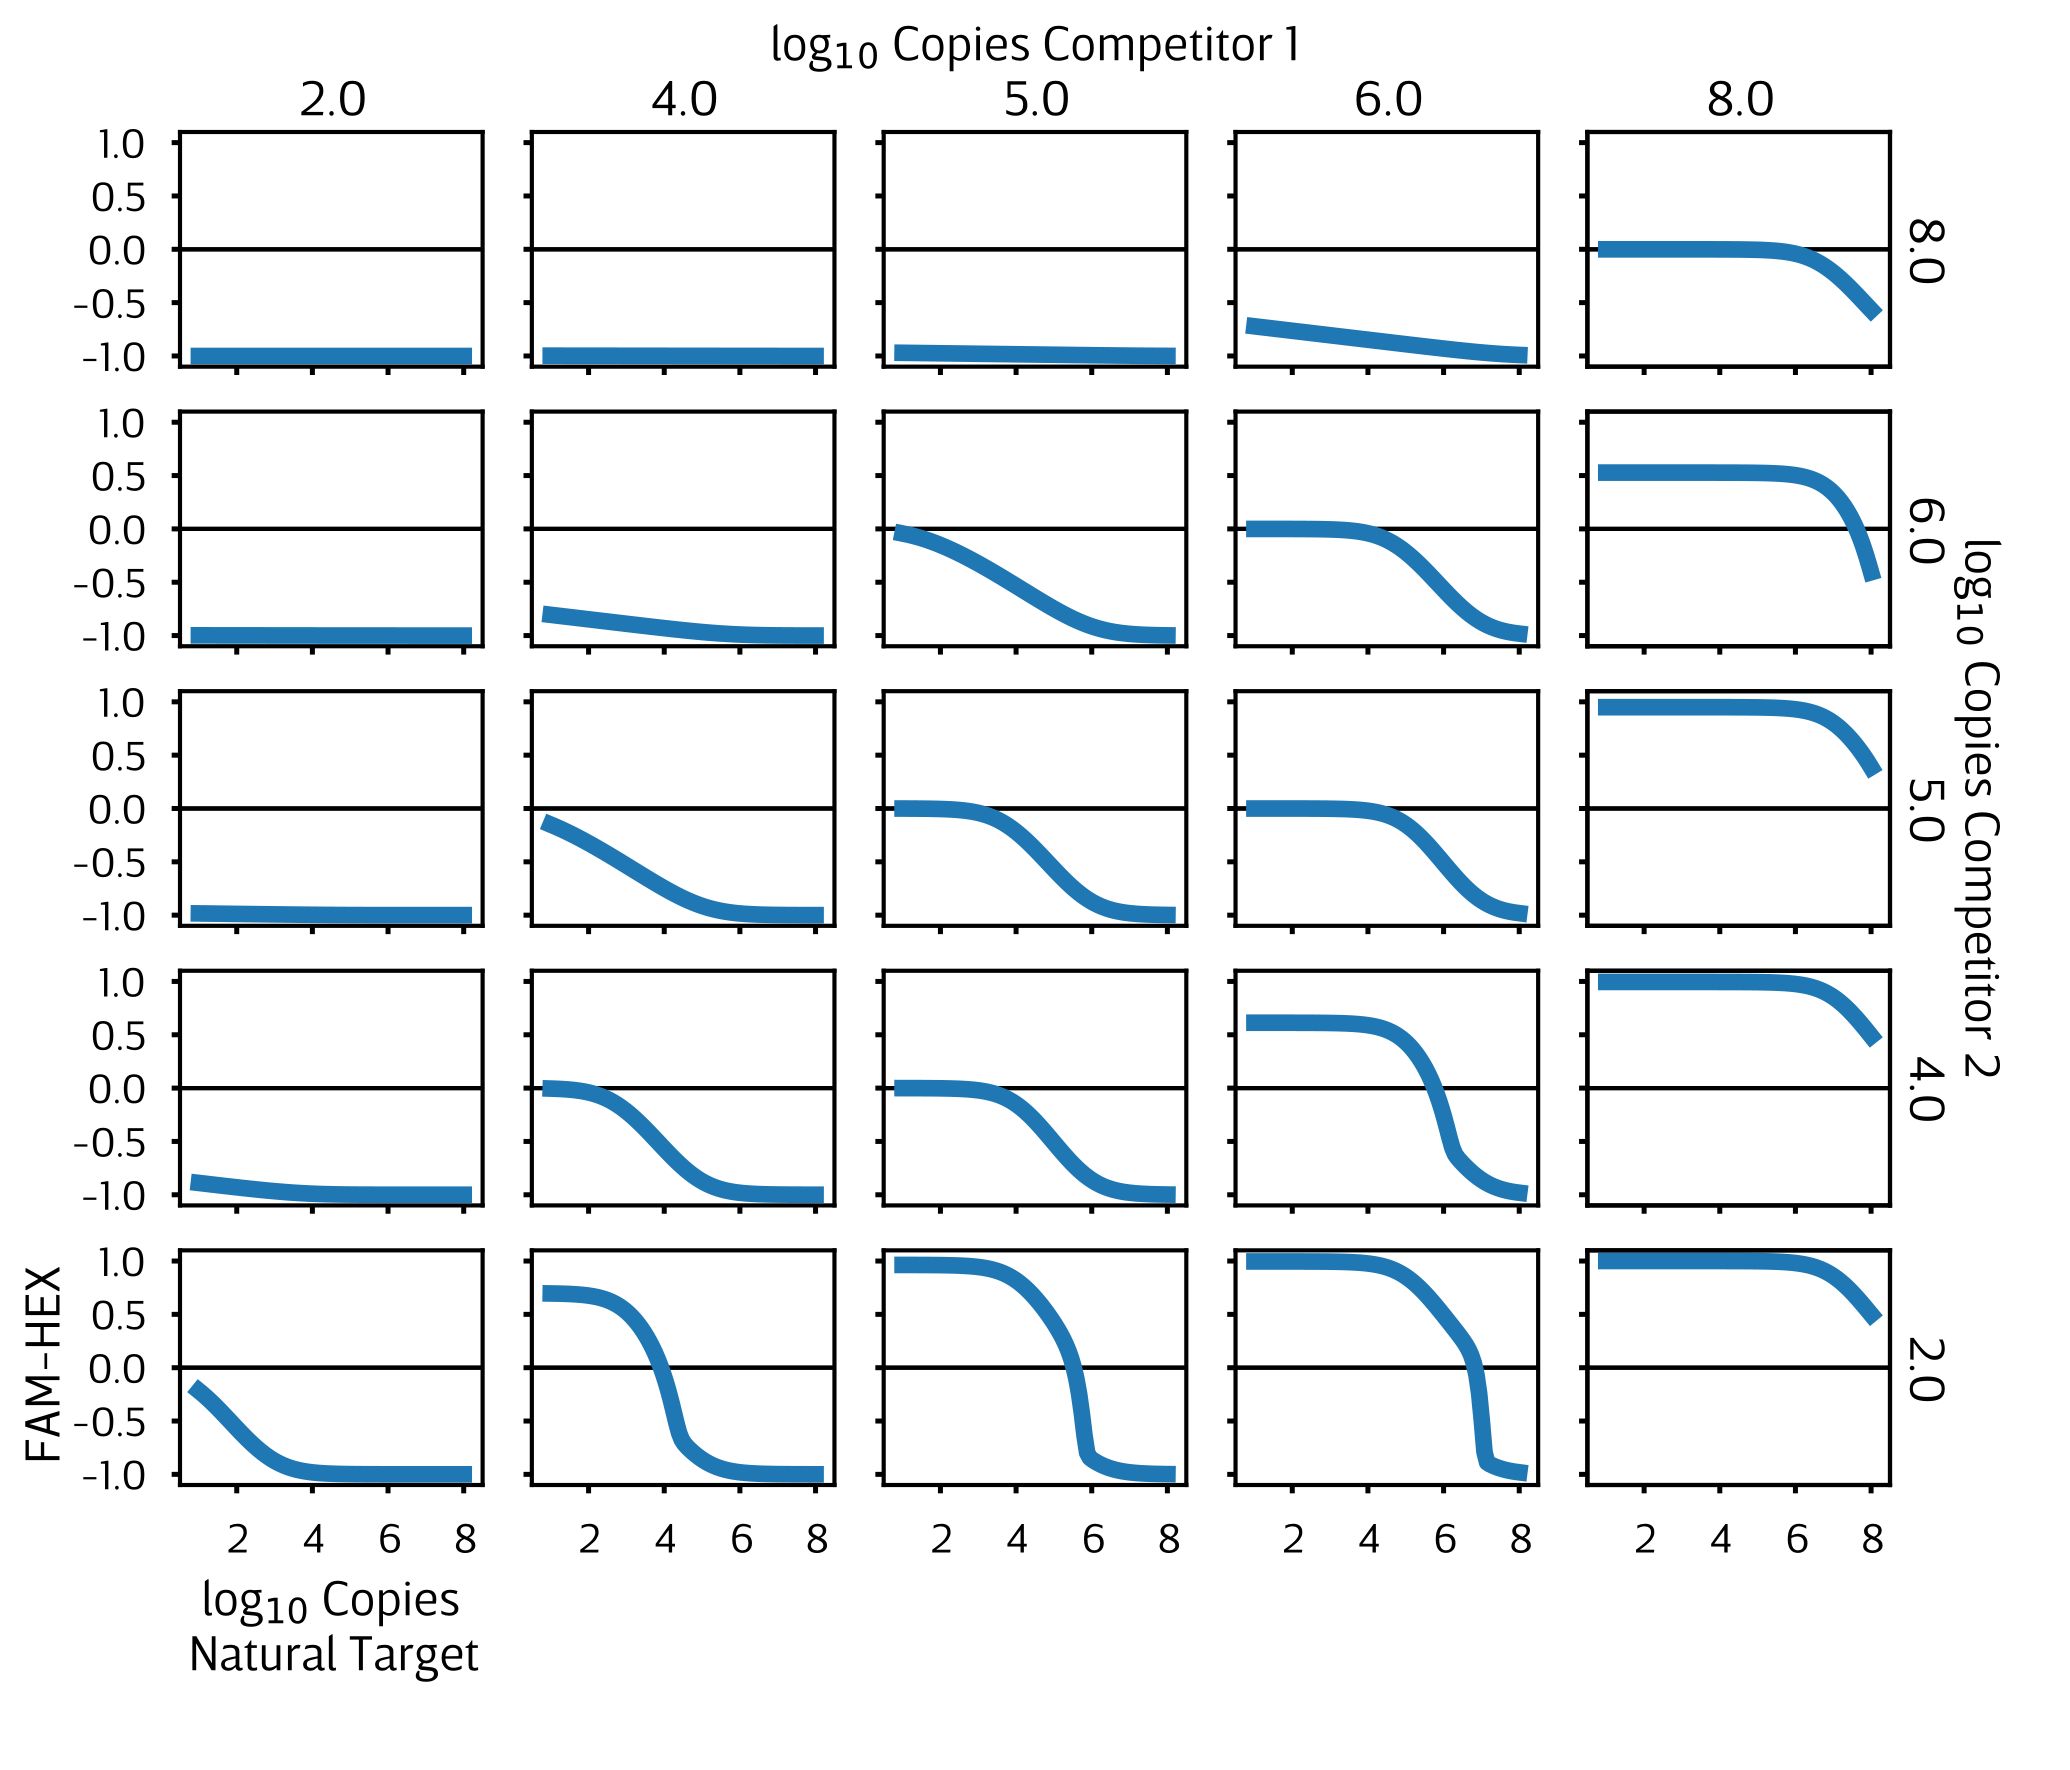

In [10]:
# Hypothetical non-ideal system

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    wt_lgQ, sol = sym_tripartite(
        ref1_rate=0.7,
        ref1_lgQ=ref1_lgQ,
        ref2_rate=0.7,
        ref2_lgQ=ref2_lgQ,
        wt_rate=0.7,
        wt_lgQ_fun=None,
    )
    ax.plot(wt_lgQ, sol)

    ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(
    r"log$_{10}$ Copies" + "\nNatural Target", fontsize=labelsize, labelpad=2
)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="floral_wildebeest")

# ARG1 system: ideal

wt_rate=0.822 | ref1_rate=0.519 | ref2_rate=0.497
Saving fig_S9C__subtle_dugong in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


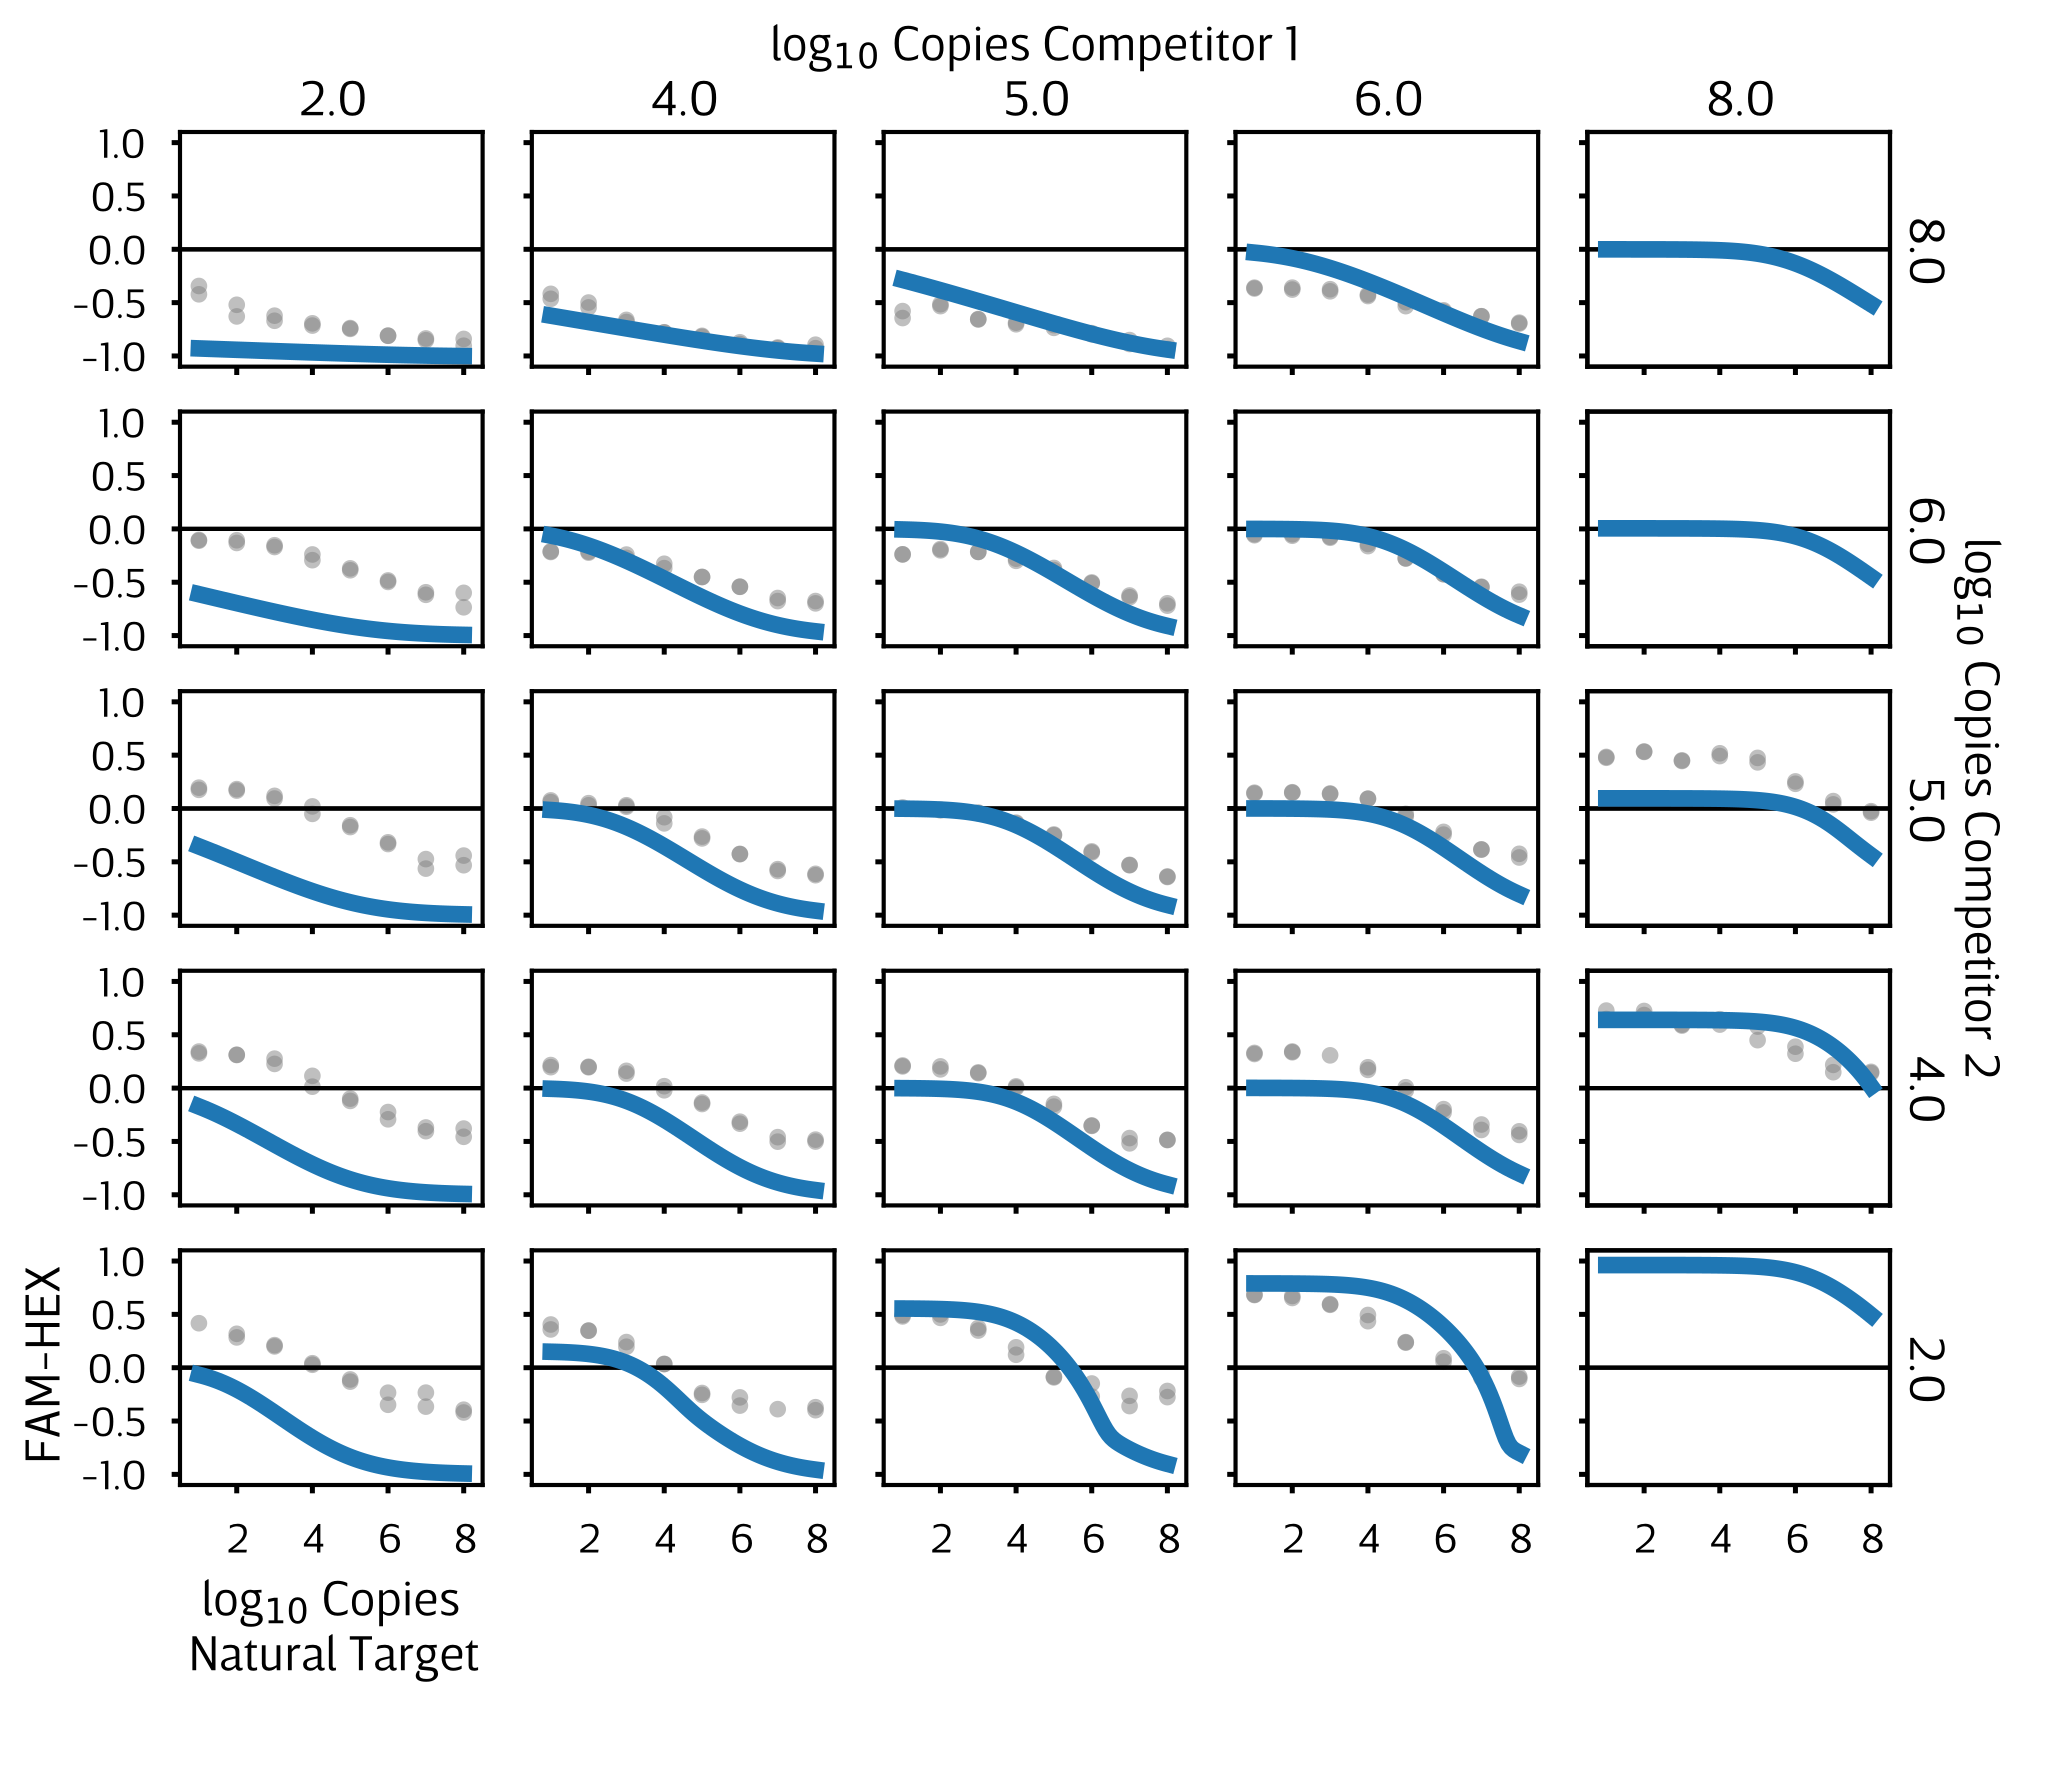

In [11]:
# Actual ideal system

wt_data = ps[ps.Target == "S036.5"]
ref1_data = ps[ps.Target == "S057.3.2"]
ref2_data = ps[ps.Target == "S057.4.2"]

ref1_rate = ref1_data["r"].mean()
ref2_rate = ref2_data["r"].mean()
wt_rate = wt_data["r"].mean()

ref1_drift = ref1_data["m"].mean()
ref2_drift = ref2_data["m"].mean()
wt_drift = wt_data["m"].mean()

wt_lgQ_fun = get_lg10_Q_fun(wt_data)
ref1_lgQ_fun = get_lg10_Q_fun(ref1_data)
ref2_lgQ_fun = get_lg10_Q_fun(ref2_data)

print(f"{wt_rate=:.3f} | {ref1_rate=:.3f} | {ref2_rate=:.3f}")

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

rmses_ARG1 = {}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    wt_lgQ, sol = sym_tripartite(
        ref1_rate=ref1_rate,
        ref1_lgQ=ref1_lgQ_fun(ref1_lgQ),
        ref2_rate=ref2_rate,
        ref2_lgQ=ref2_lgQ_fun(ref2_lgQ),
        wt_rate=wt_rate,
        wt_start=1,
        wt_lgQ_fun=wt_lgQ_fun,
        ref1_drift=ref1_drift,
        ref2_drift= ref2_drift,
        wt_drift=wt_drift,
    )
    
    ax.plot(wt_lgQ, sol)
    
    these_endpoints = endpoints_B[
        (endpoints_B["log_S057.3.2"] == ref1_lgQ)
        & (endpoints_B["log_S057.4.2"] == ref2_lgQ)
    ]
    
    if not these_endpoints.empty:
        ax.scatter(
            these_endpoints["log_S036.5"],
            these_endpoints["FAM-HEX"],
            s=4,
            color="grey",
            edgecolor="none",
            alpha=0.5,
            zorder=-10,
        )
        
        wt_lgQ, sol = sym_tripartite(
            ref1_rate=ref1_rate,
            ref1_lgQ=ref1_lgQ_fun(ref1_lgQ),
            ref2_rate=ref2_rate,
            ref2_lgQ=ref2_lgQ_fun(ref2_lgQ),
            wt_rate=wt_rate,
            wt_pts=these_endpoints["log_S036.5"],
            wt_lgQ_fun=wt_lgQ_fun,
            ref1_drift=ref1_drift,
            ref2_drift= ref2_drift,
            wt_drift=wt_drift,
        )
    
        rmse = np.sqrt(np.mean((sol - these_endpoints["FAM-HEX"]) ** 2))
        rmses_ARG1[(ref2_lgQ, ref1_lgQ)] = rmse
        
        # ax.annotate(
        #     f"RMSE: {rmse:.2f}",
        #     xy=(0.05, 0.95),
        #     xycoords="axes fraction",
        #     fontsize=labelsize,
        #     ha="left",
        #     va="top",
        # )

    ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(
    r"log$_{10}$ Copies" + "\nNatural Target", fontsize=labelsize, labelpad=2
)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="subtle_dugong")

# GBP6 system: non-ideal

wt_rate=0.708 | ref1_rate=0.644 | ref2_rate=0.650
Saving fig_S9D__obvious_capybara in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


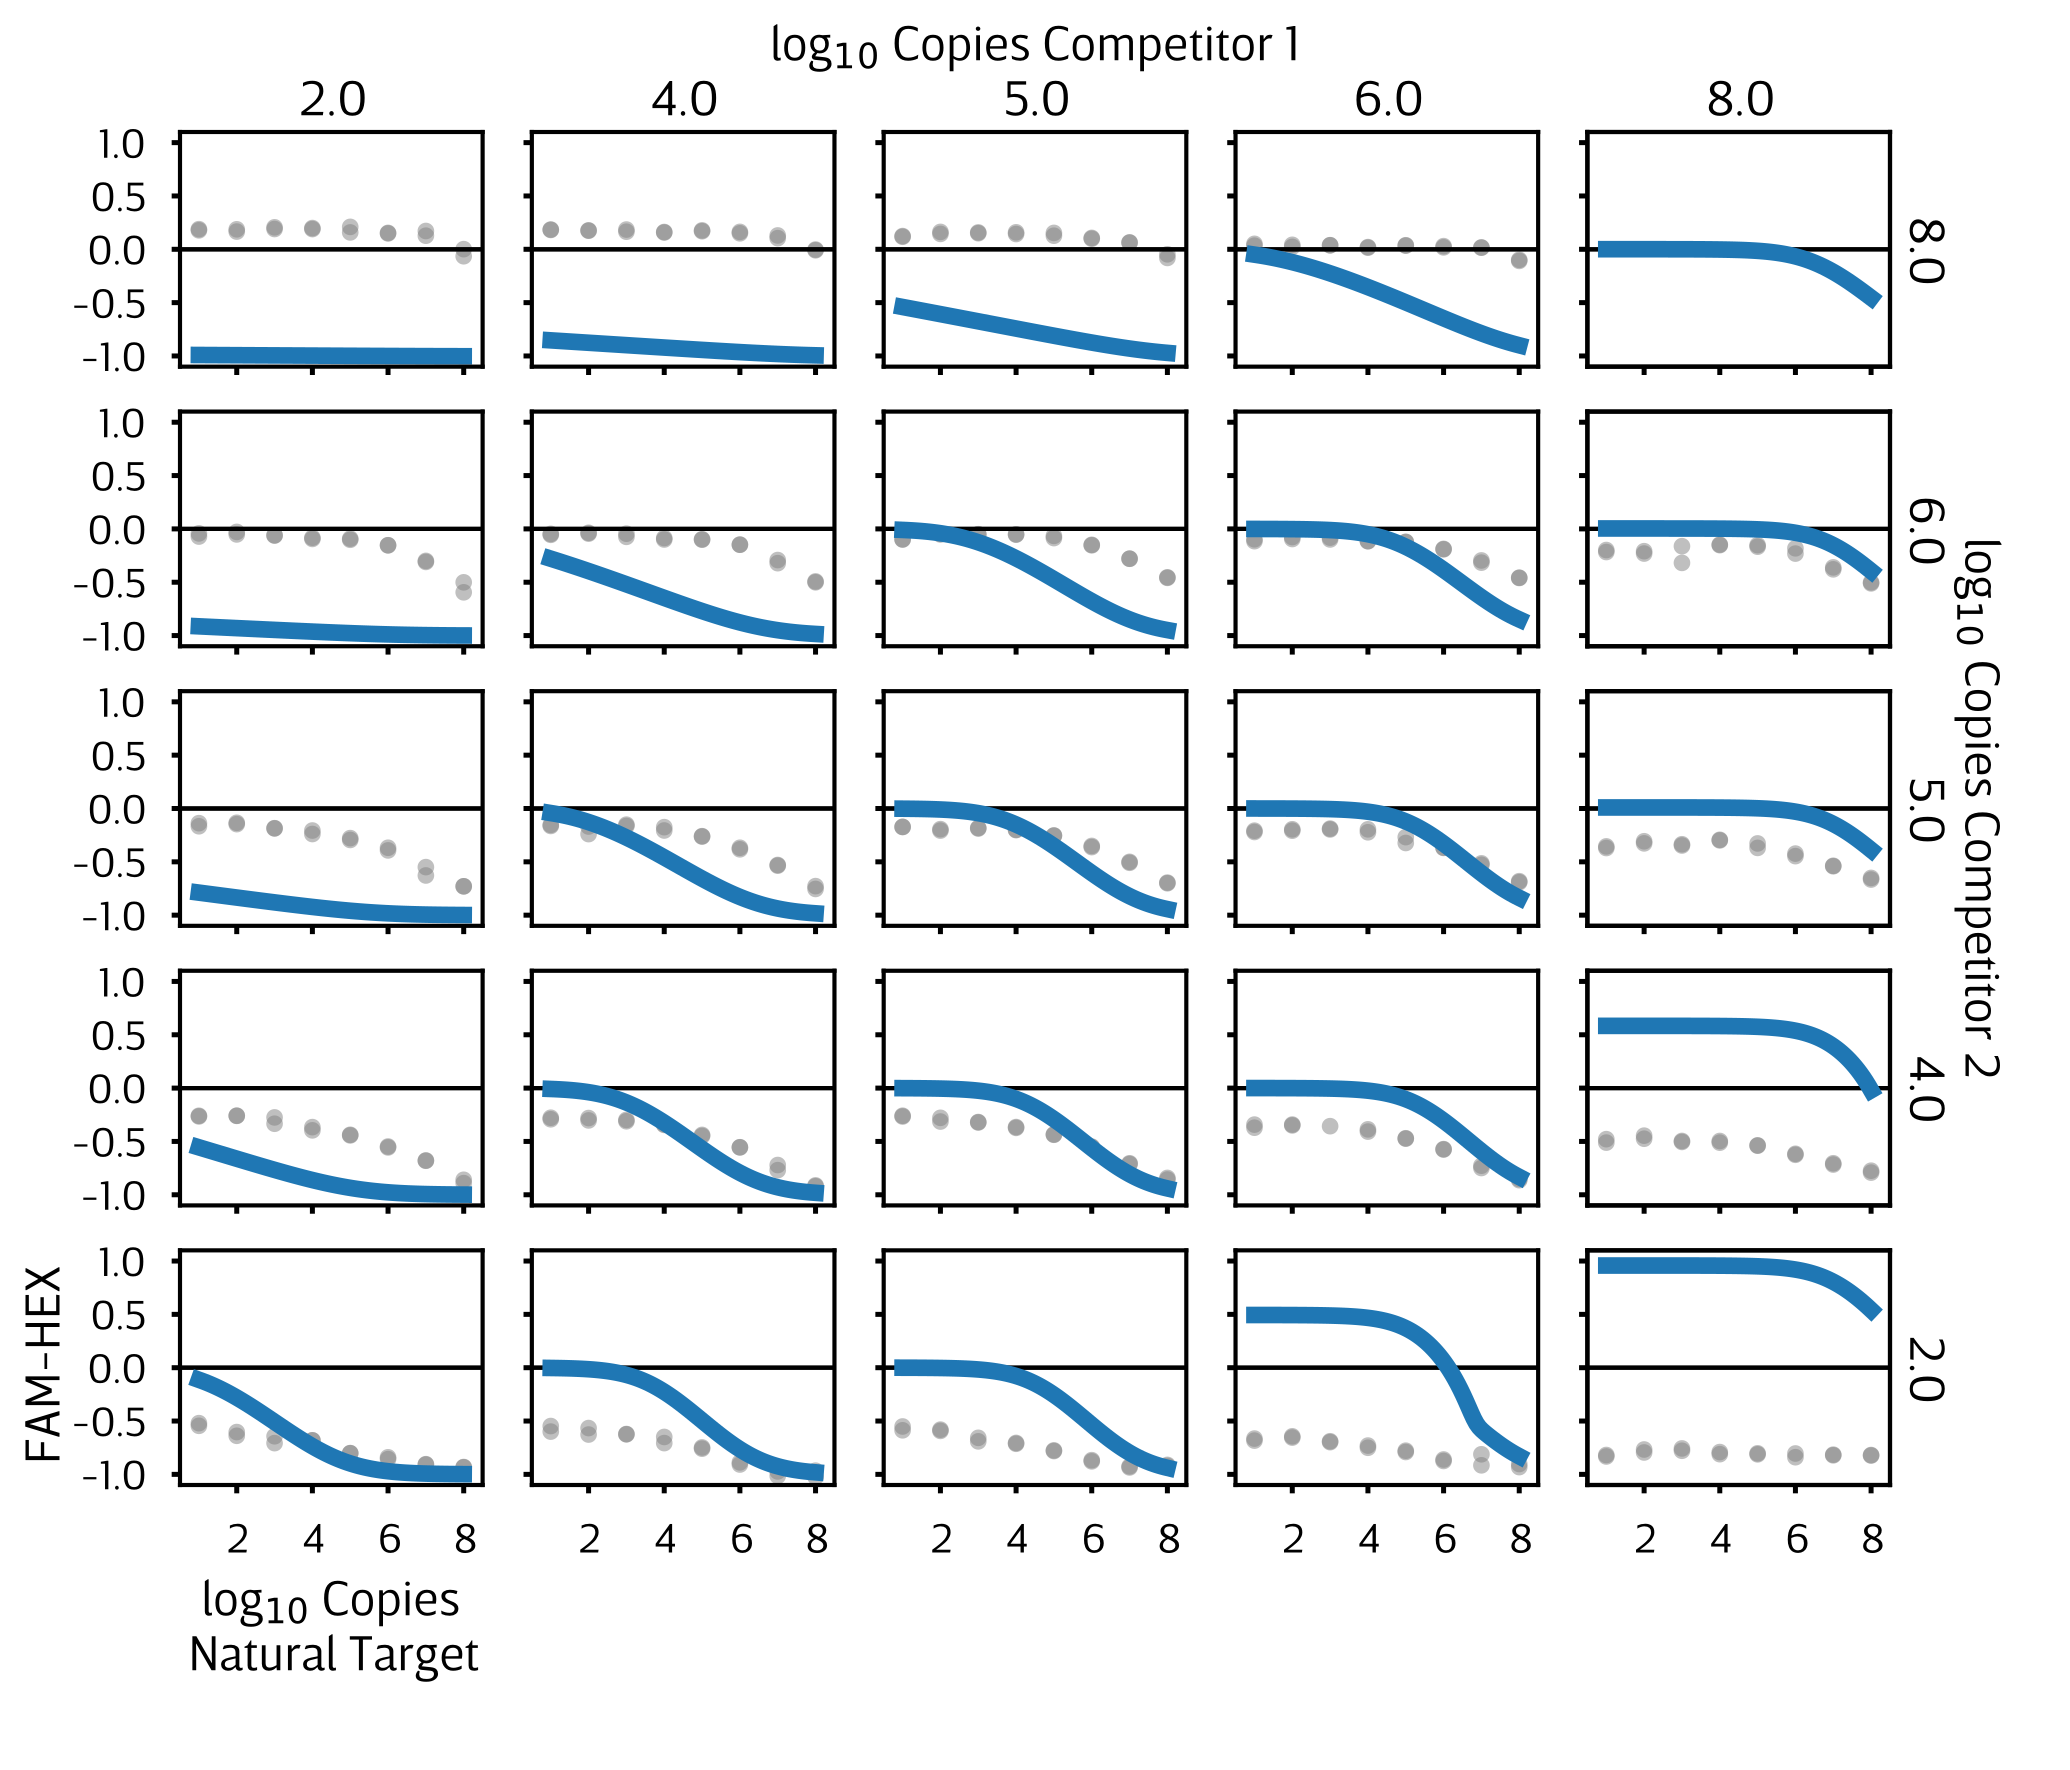

In [12]:
# Actual non-ideal system

wt_data = ps[ps.Target == "S036.0"]  # GBP6
ref1_data = ps[ps.Target == "S057.0.1"]
ref2_data = ps[ps.Target == "S057.1.2"]

wt_lgQ_fun = get_lg10_Q_fun(wt_data)
ref1_lgQ_fun = get_lg10_Q_fun(ref1_data)
ref2_lgQ_fun = get_lg10_Q_fun(ref2_data)

ref1_rate=ref1_data["r"].mean()
ref2_rate=ref2_data["r"].mean()
wt_rate=wt_data["r"].mean()

ref1_drift = ref1_data["m"].mean()
ref2_drift = ref2_data["m"].mean()
wt_drift = wt_data["m"].mean()


print(f"{wt_rate=:.3f} | {ref1_rate=:.3f} | {ref2_rate=:.3f}")

fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

rmses_GBP6 = {}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    wt_lgQ, sol = sym_tripartite(
        ref1_rate=ref1_rate,
        ref1_lgQ=ref1_lgQ_fun(ref1_lgQ),
        ref2_rate=ref2_rate,
        ref2_lgQ=ref2_lgQ_fun(ref2_lgQ),
        wt_rate=wt_rate,
        wt_start=1,
        wt_lgQ_fun=wt_lgQ_fun,
        ref1_drift=ref1_drift,
        ref2_drift= ref2_drift,
        wt_drift=wt_drift,
    )
    
    these_endpoints = endpoints_A[
        (endpoints_A["log_S057.0.1"] == ref1_lgQ)
        & (endpoints_A["log_S057.1.2"] == ref2_lgQ)
    ]
    
    ax.plot(wt_lgQ, sol)
    
    if not these_endpoints.empty:
        ax.scatter(
            these_endpoints["log_S036.0"],
            these_endpoints["FAM-HEX"],
            s=4,
            color="grey",
            edgecolor="none",
            alpha=0.5,
            zorder=-10,
        )
        
        wt_lgQ, sol = sym_tripartite(
            ref1_rate=ref1_rate,
            ref1_lgQ=ref1_lgQ_fun(ref1_lgQ),
            ref2_rate=ref2_rate,
            ref2_lgQ=ref2_lgQ_fun(ref2_lgQ),
            wt_rate=wt_rate,
            wt_pts=these_endpoints["log_S036.0"],
            wt_lgQ_fun=wt_lgQ_fun,
            ref1_drift=ref1_drift,
            ref2_drift= ref2_drift,
            wt_drift=wt_drift,
        )
    
        rmse = np.sqrt(np.mean((sol - these_endpoints["FAM-HEX"]) ** 2))
        rmses_GBP6[(ref2_lgQ, ref1_lgQ)] = rmse
        
        # ax.annotate(
        #     f"RMSE: {rmse:.2f}",
        #     xy=(0.05, 0.95),
        #     xycoords="axes fraction",
        #     fontsize=labelsize,
        #     ha="left",
        #     va="top",
        # )

    ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(
    r"log$_{10}$ Copies" + "\nNatural Target", fontsize=labelsize, labelpad=2
)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="obvious_capybara")

# RMSE plots

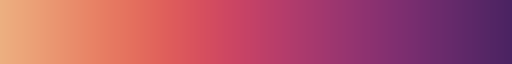

In [13]:
from matplotlib import cm
from matplotlib import colormaps

all_rmses = np.array(list(rmses_ARG1.values()) + list(rmses_GBP6.values()))

rmse_norm = cm.colors.Normalize()
rmse_norm(all_rmses)

cmap = colormaps["flare"]
cmap

RMSE ARG1: 0.30 ± 0.17
Saving fig_S9E__durable_albatross in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


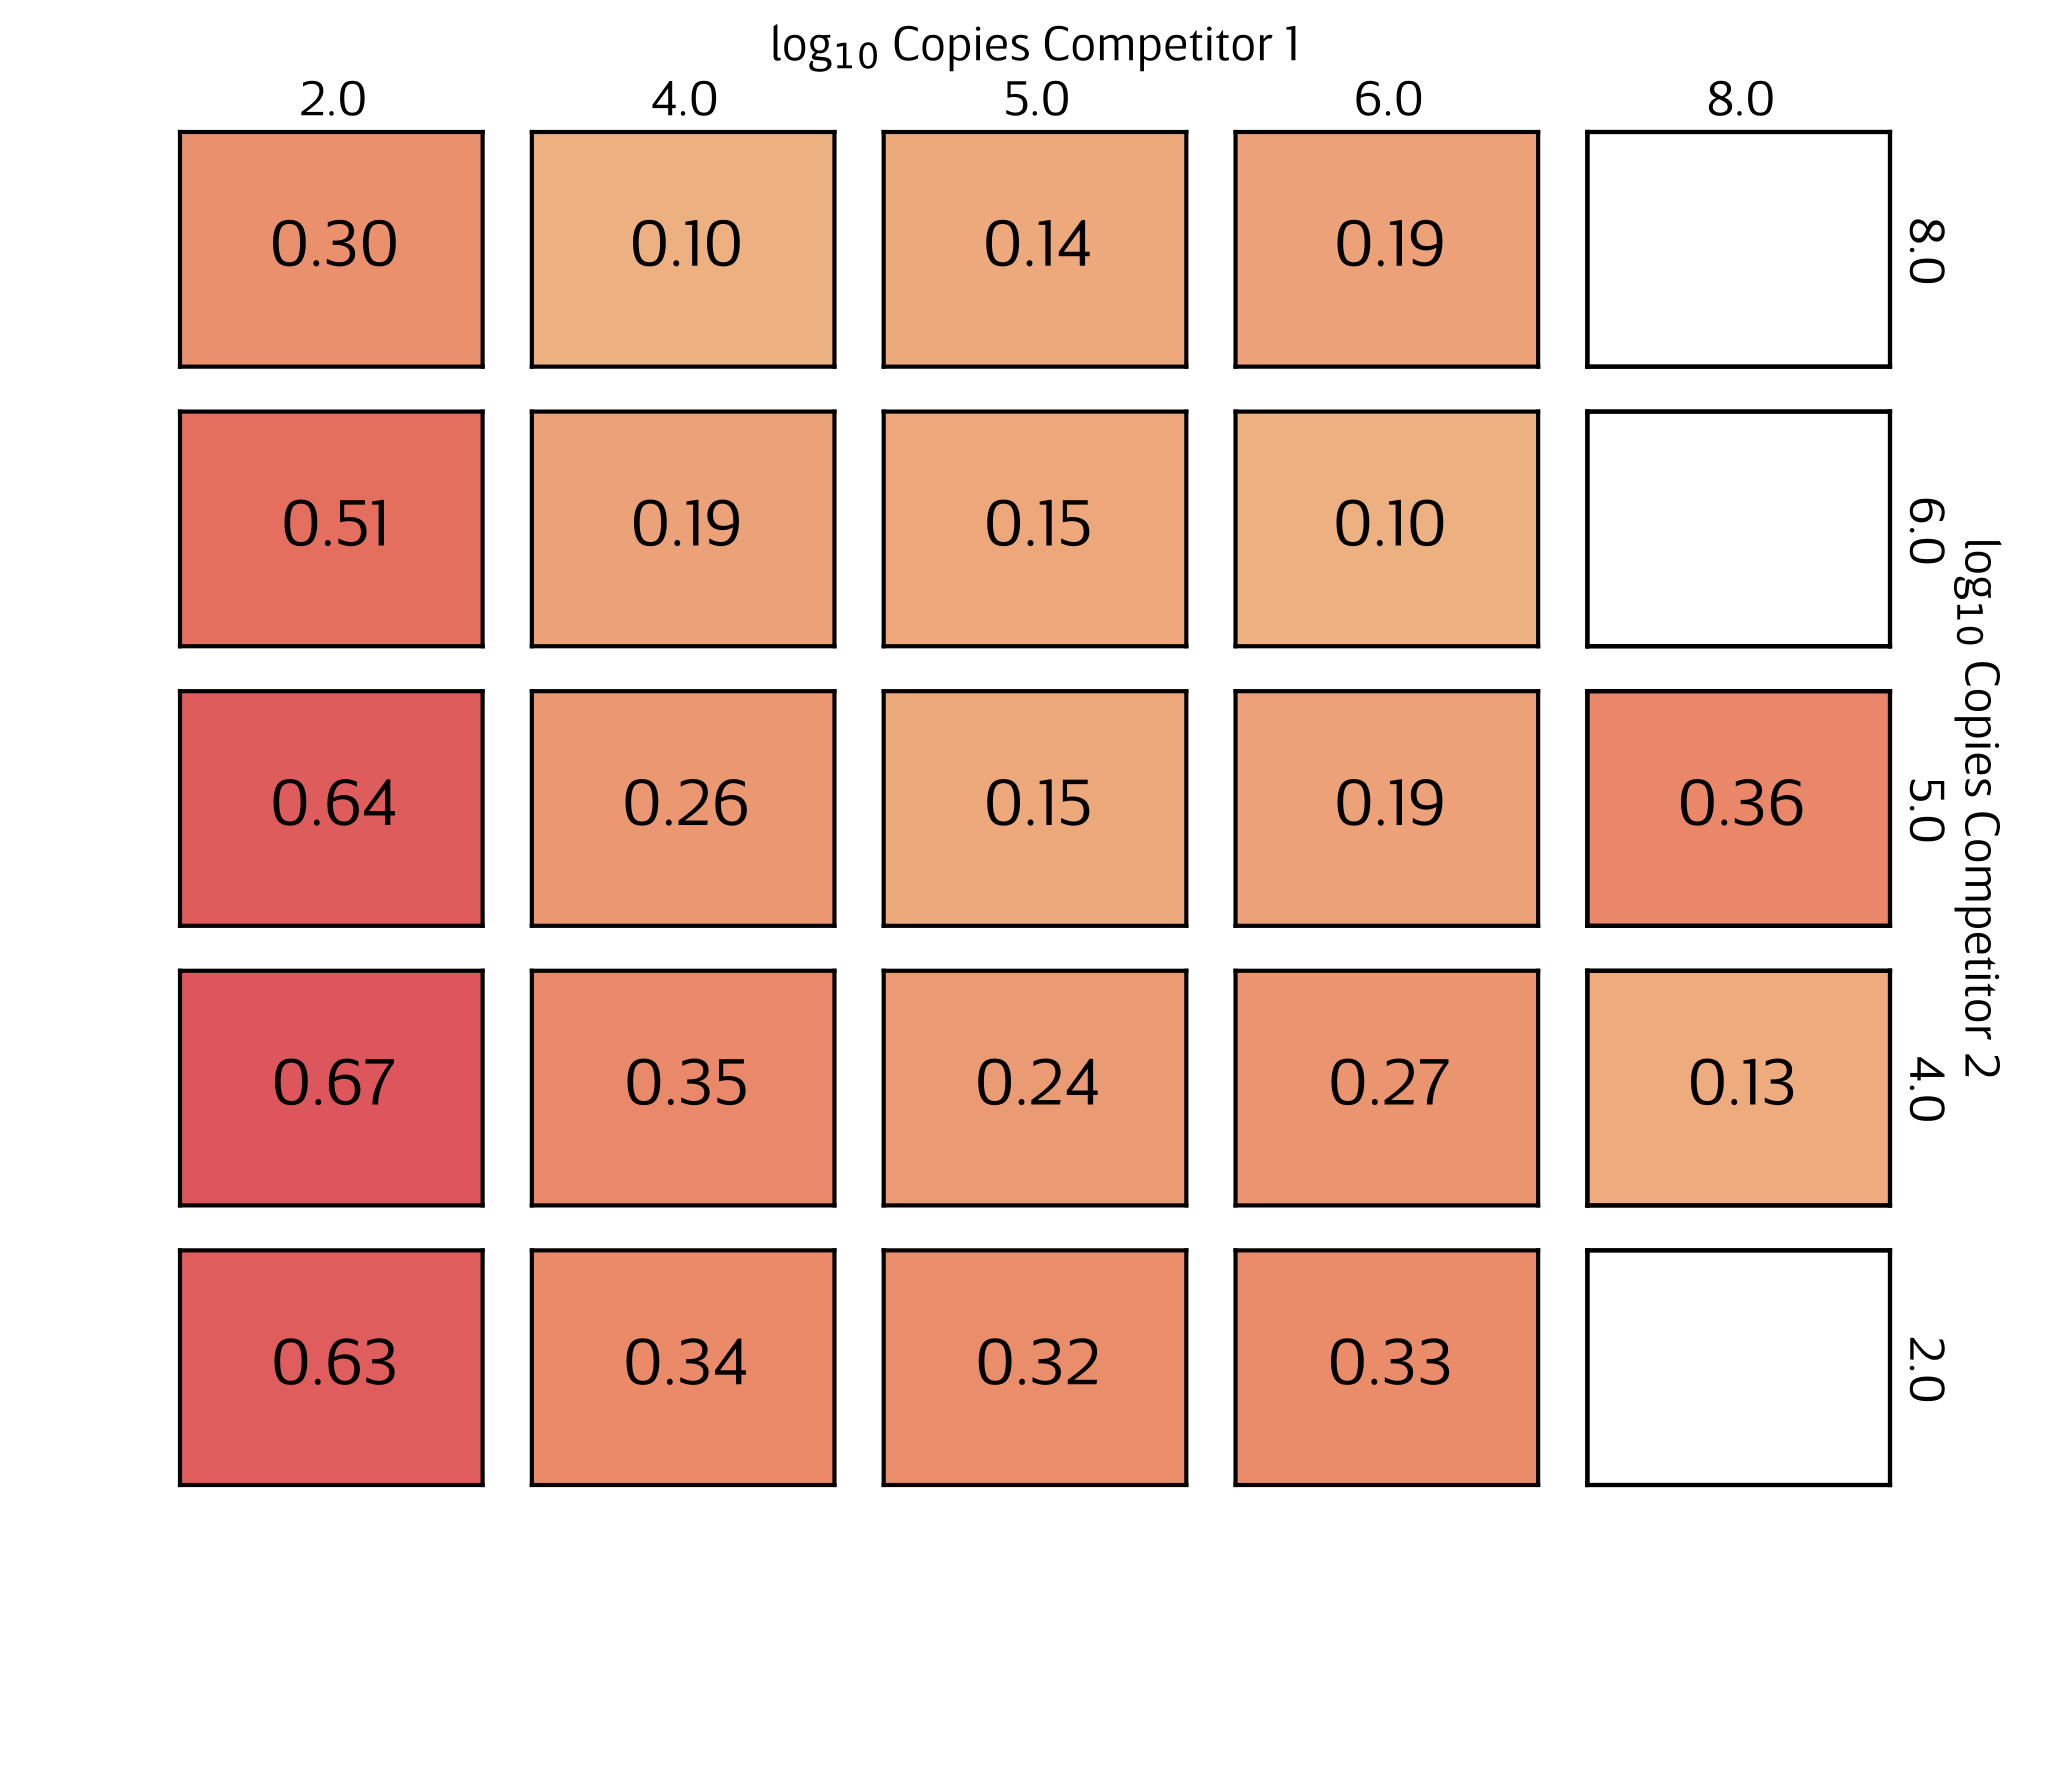

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}



for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    if (ref2_lgQ, ref1_lgQ) in rmses_ARG1:
        rmse = rmses_ARG1[(ref2_lgQ, ref1_lgQ)]
    else:
        ax.set_facecolor('white')
        continue
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    ax.annotate(
        f"{rmse:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        fontsize=titlesize,
        ha="center",
        va="center",
    )
    
format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5], hline=False)

plt.setp(
    axs,
    yticks=[],
    xticks=[],
)

print(f"RMSE ARG1: {np.mean(list(rmses_ARG1.values())):.2f} ± {np.std(list(rmses_ARG1.values())):.2f}")

savefig(plt.gcf(), alias="durable_albatross", transparent_svg=False)

RMSE GBP6: 0.55 ± 0.39
Saving fig_S9F__fragile_buffalo in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


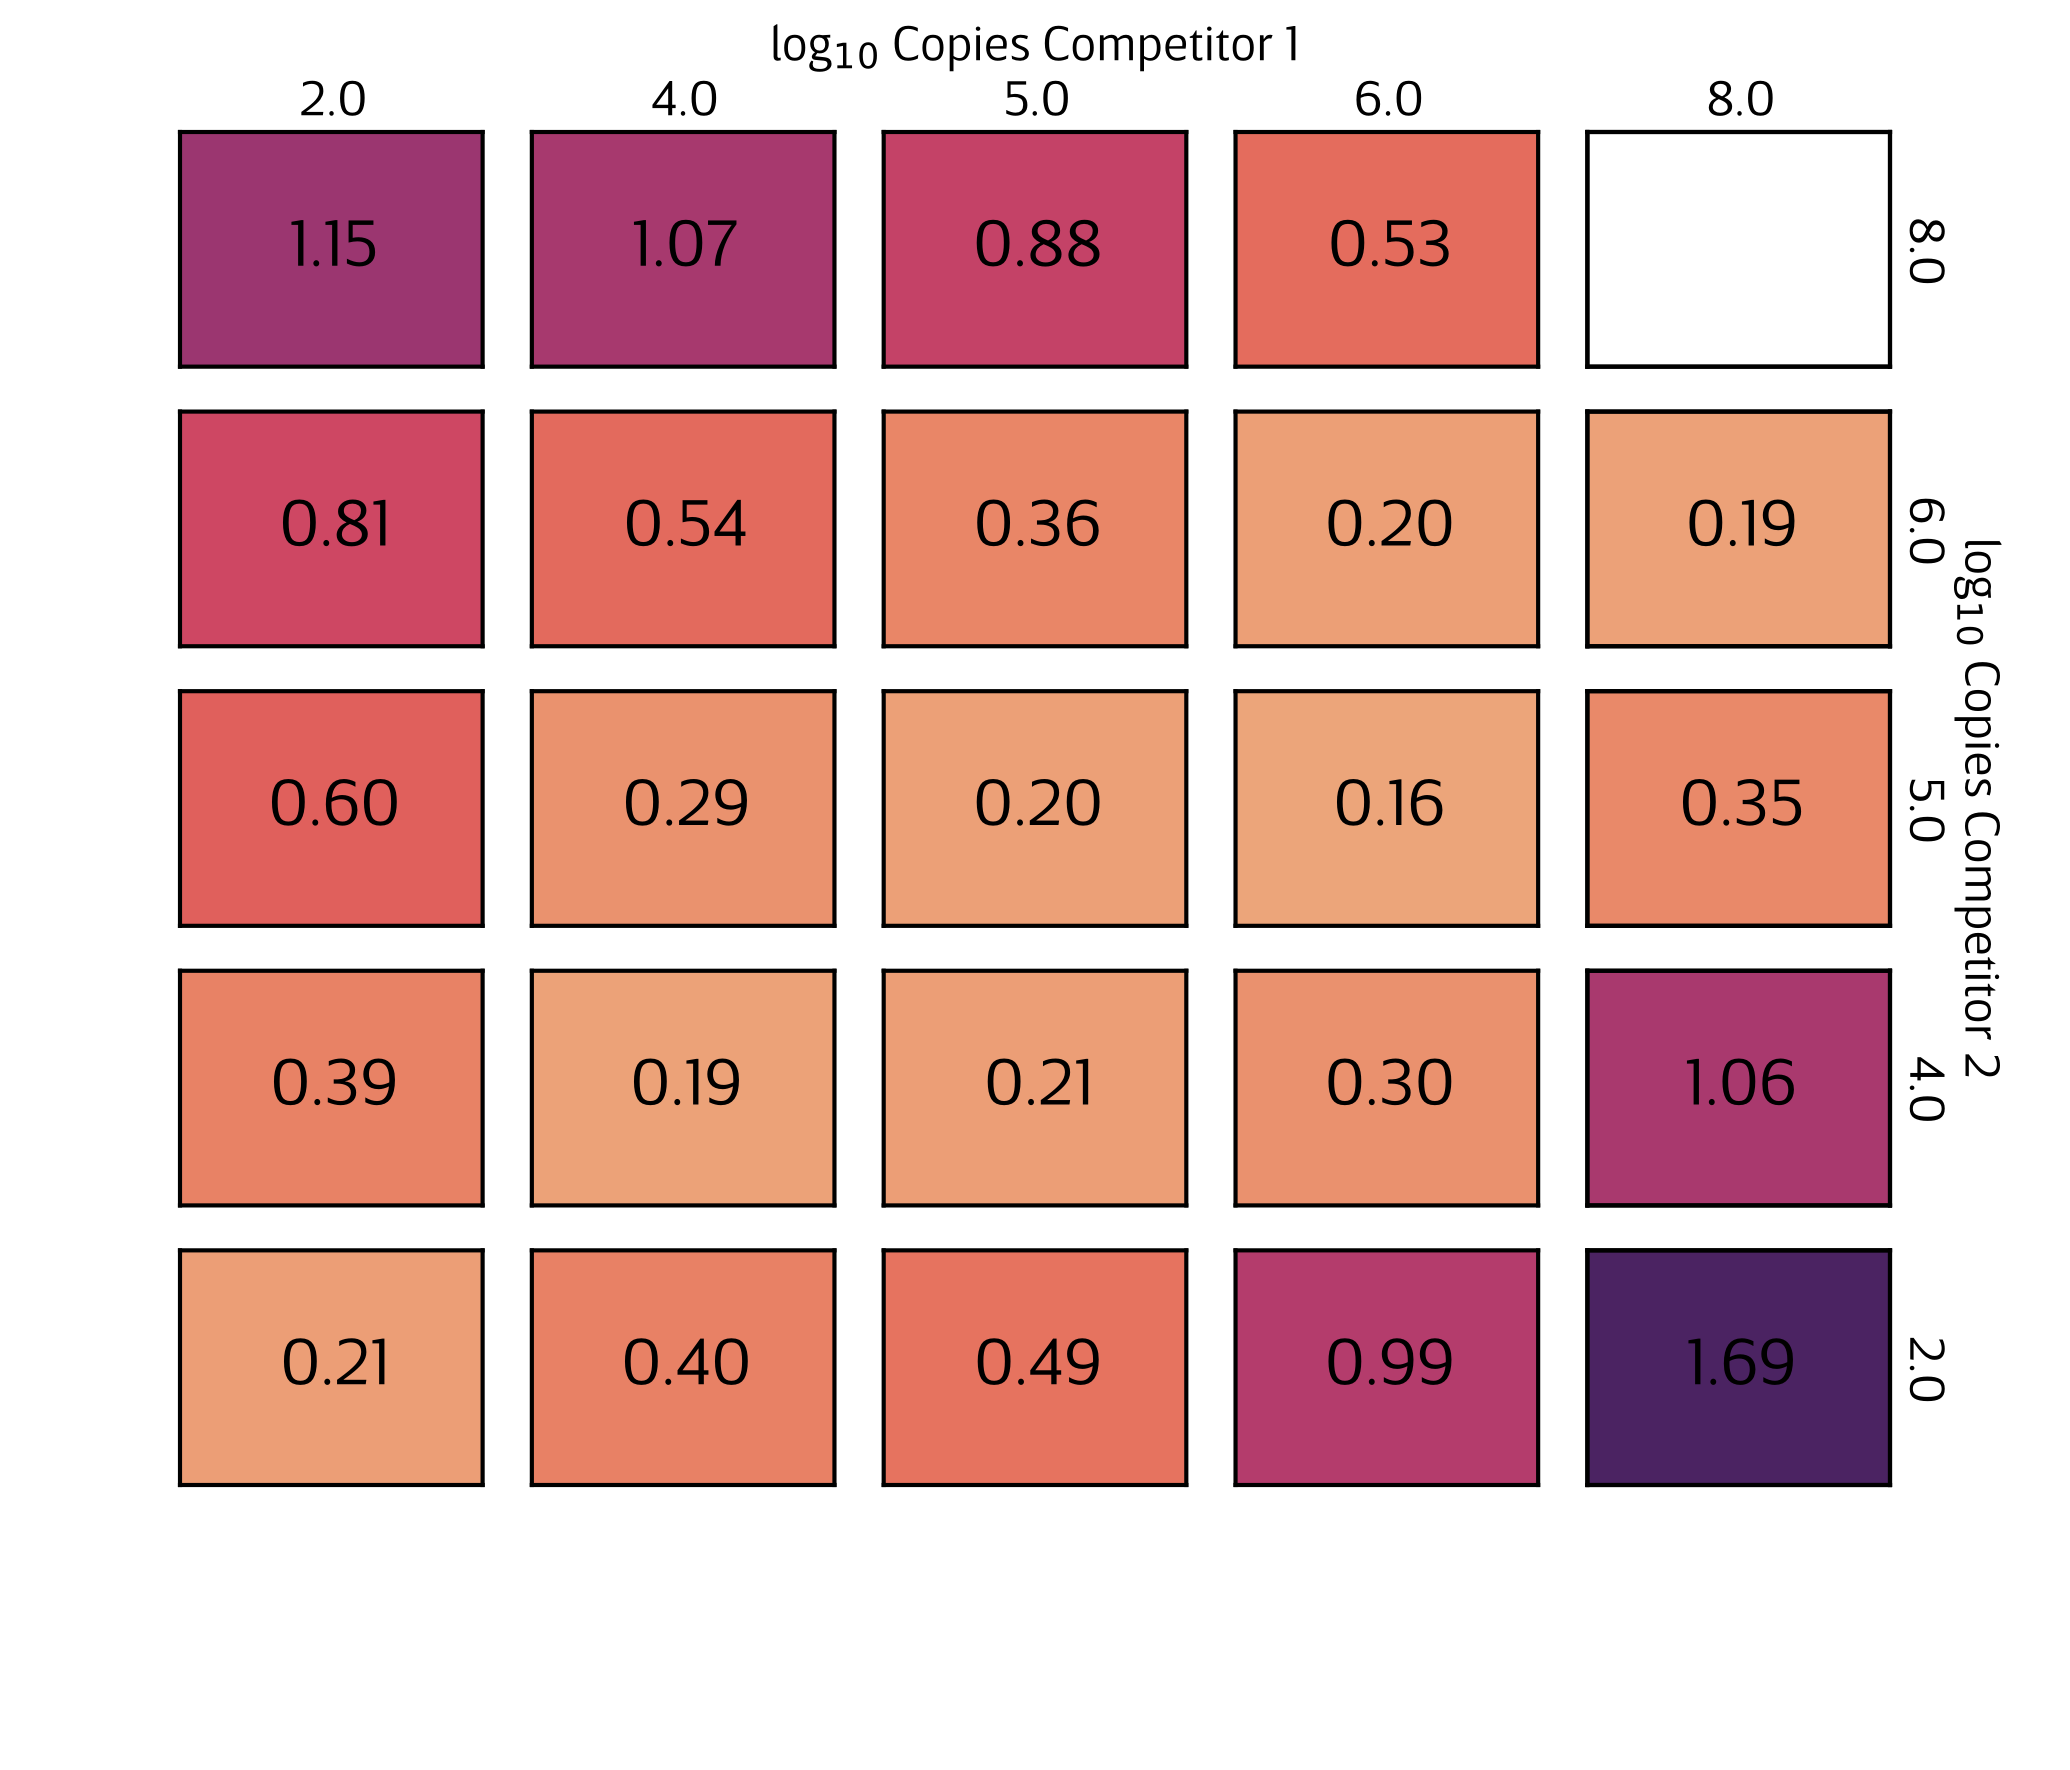

In [15]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}



for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
    if (ref2_lgQ, ref1_lgQ) in rmses_GBP6:
        rmse = rmses_GBP6[(ref2_lgQ, ref1_lgQ)]
    else:
        ax.set_facecolor('white')
        continue
    ax.set_facecolor(cmap(rmse_norm(rmse)))
    ax.annotate(
        f"{rmse:.2f}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        fontsize=titlesize,
        ha="center",
        va="center",
    )
    
format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5], hline=False)
plt.setp(
    axs,
    yticks=[],
    xticks=[],
)

print(f"RMSE GBP6: {np.mean(list(rmses_GBP6.values())):.2f} ± {np.std(list(rmses_GBP6.values())):.2f}")

savefig(plt.gcf(), alias="fragile_buffalo", transparent_svg=False)

Saving fig_S9E__durable_albatross__legend in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


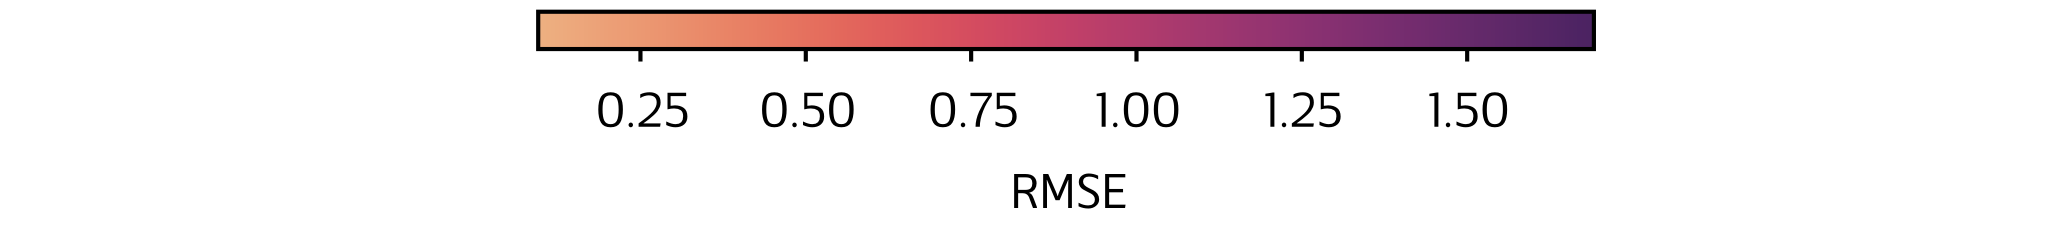

Saving fig_S9F__fragile_buffalo__legend in /home/john/projects/can-manuscript/fig_S9__soft_lamprey/graphics: [.svg] [.png] done


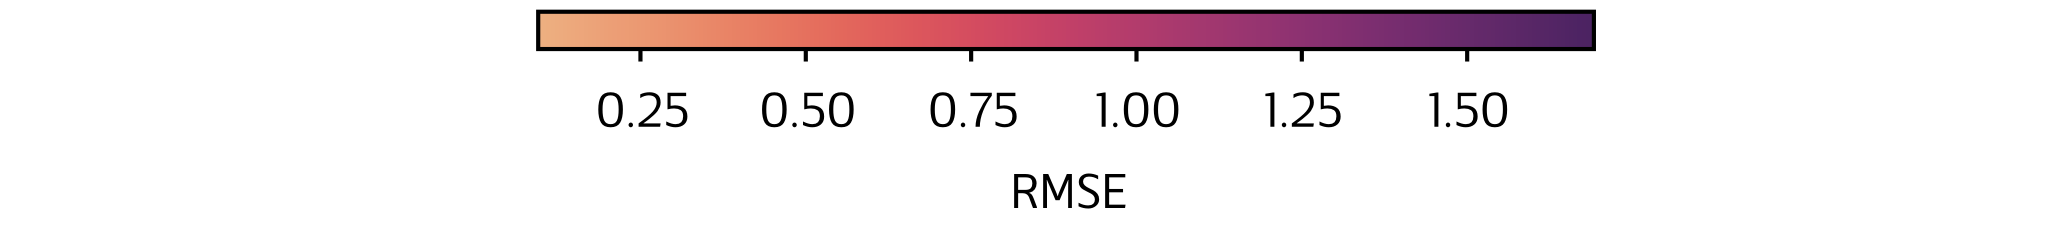

In [16]:
width = 3.45
height = 0.829 / 2
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

fig = plt.figure()
fig.set_figwidth(width)
fig.set_figheight(height)

ax = plt.axes([0.26, 0.8, 0.51, 0.15])

# Dummy data for the colorbar
dummy_data = np.array([0, 1])
norm = mpl.colors.Normalize(vmin=all_rmses.min(), vmax=all_rmses.max())

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set a dummy array for ScalarMappable

# Add the colorbar to the specified axes
cbar = fig.colorbar(
    sm, cax=ax, orientation="horizontal", shrink=0.6, aspect=20, pad=0.5
)

cbar.ax.tick_params(labelsize=ticklabelsize, width=0.5, length=1.5)
cbar.set_label("RMSE", fontsize=labelsize)

savefig(plt.gcf(), alias="durable_albatross", extra="legend")
savefig(plt.gcf(), alias="fragile_buffalo", extra="legend")